In [2]:
DATA_DIR = '../../data/' # for local
# DATA_DIR = 'drive/My Drive/colab/' # for colab

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import regression_common
import matplotlib.pyplot as plt

from random import sample
from nilearn import plotting
from nilearn import datasets
from nilearn.input_data import NiftiMasker

#To ensure reproducibility
random.seed(39)
np.random.seed(39)

/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/hasnainmamdani/Academics/McGill/thesis/scikit-learn/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.

In [4]:
imgs = np.load(DATA_DIR + 'binary_imgs.npy')
mask_img = datasets.load_mni152_brain_mask()
masker = NiftiMasker(mask_img=mask_img, memory='nilearn_cache')
masker = masker.fit()

## Analysis with 100 PC components

In [5]:
# Calculate 100 PC components
pca = PCA(n_components=100, copy=False)
X_pc = pca.fit_transform(imgs)
    
X_pc.shape

(1401, 100)

In [6]:
patient_df = pd.read_hdf(DATA_DIR + 'patients.h5', 'p')
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(np.array(patient_df[patient_df.columns[5:11]]))
print(Y.shape)

(1401, 6)


In [7]:
# Mixup implementation
def mixup_data(X, Y, alpha=0.1, mul_factor=10):
    
    rs = np.random.RandomState(39)
    n = X.shape[0]
    
    mixed_X = np.empty((n*(mul_factor-1), X.shape[1]))
    mixed_Y = np.empty((n*(mul_factor-1), Y.shape[1]))
    
    X1_idx = np.empty((n*(mul_factor-1)), dtype=int)
    X2_idx = np.empty((n*(mul_factor-1)), dtype=int)
    lambdas = np.empty((n*(mul_factor-1)))
    
    for i in range(mul_factor-1):
        
        # sample more than needed as some will be filtered out
        lam = np.random.beta(alpha, alpha, size=round(n*1.2))
        
        # original data vectors will be concatenated later
        lam = lam[(lam!=0.0) & (lam!=1.0)][:n][:, None]
        
        shuffle_idx = rs.choice(np.arange(n), n, replace=False)

        mixed_X[i*n : (i+1)*n] = lam * X + (1 - lam) * X[shuffle_idx, :]
        mixed_Y[i*n : (i+1)*n] = lam * Y + (1 - lam) * Y[shuffle_idx, :]
        
        X1_idx[i*n : (i+1)*n] = np.arange(n)
        X2_idx[i*n : (i+1)*n] = shuffle_idx
        lambdas[i*n : (i+1)*n] = lam.reshape(n)
        
    # concatenate original data vectors
    mixed_X = np.append(mixed_X, X, axis=0)
    mixed_Y = np.append(mixed_Y, Y, axis=0)
    
    X1_idx = np.append(X1_idx, np.arange(n), axis=0)
    X2_idx = np.append(X2_idx, rs.choice(np.arange(n), n, replace=False), axis=0)
    lambdas = np.append(lambdas, np.ones(n), axis=0)
            
    return mixed_X, mixed_Y, X1_idx, X2_idx, lambdas

In [12]:
mixed_X, mixed_Y, X1_idx, X2_idx, lambdas = mixup_data(X_pc, Y, alpha=5.0, mul_factor=5)
print(mixed_X.shape)

(7005, 100)


-------------------------------------------------------------------------------------------------------------

Scores for X₁:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Scores for X₂:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Lambda:			 0.45756639960526313
Scores for mixup-ed data: [-0.07582129  0.14418367 -0.22010234 -0.25709291 -0.0538593  -0.32702889]


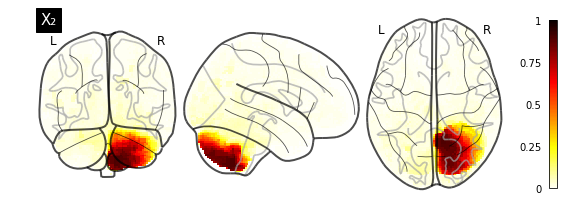

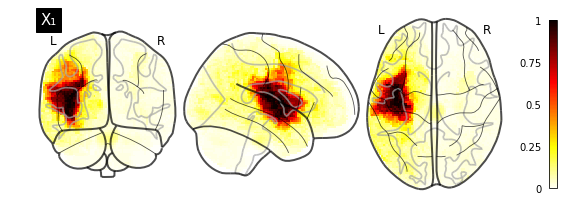

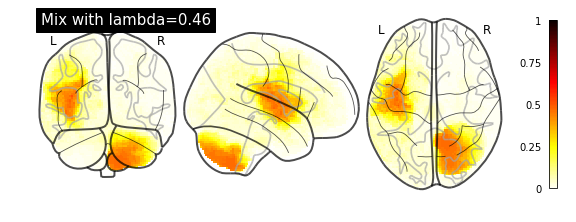

-------------------------------------------------------------------------------------------------------------

Scores for X₁:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Scores for X₂:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Lambda:			 0.27718049172352643
Scores for mixup-ed data: [ 0.13781651  0.29427232 -0.50089174  0.10334431 -0.20034133 -0.62995471]


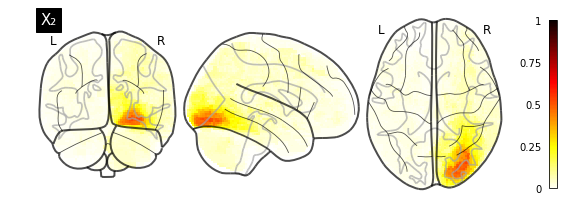

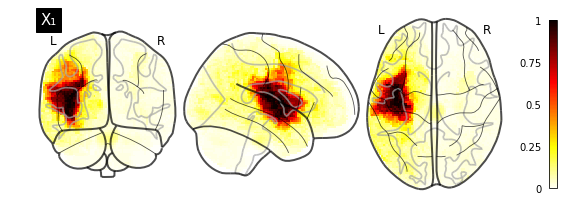

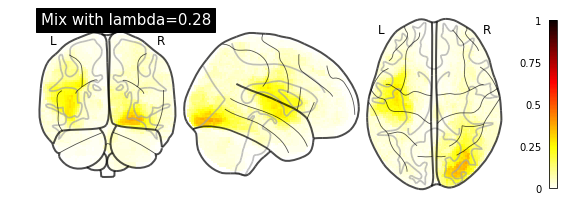

-------------------------------------------------------------------------------------------------------------

Scores for X₁:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Scores for X₂:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Lambda:			 0.4270740455047698
Scores for mixup-ed data: [-0.0048975  -0.33983062 -0.45610857 -0.88389839 -0.17501948  0.12037243]


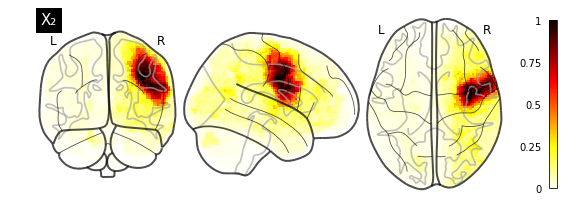

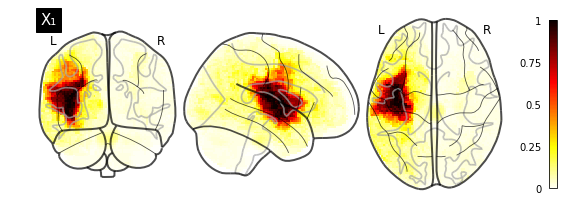

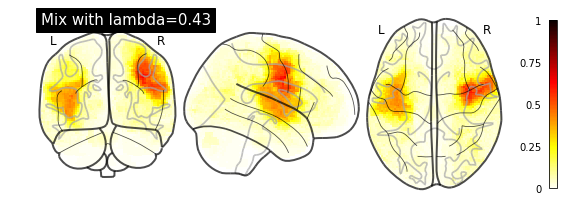

-------------------------------------------------------------------------------------------------------------

Scores for X₁:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Scores for X₂:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Lambda:			 0.5905596727507847
Scores for mixup-ed data: [-0.10178352 -0.04559793 -0.89044092 -0.91110469 -0.31614657 -1.50593795]


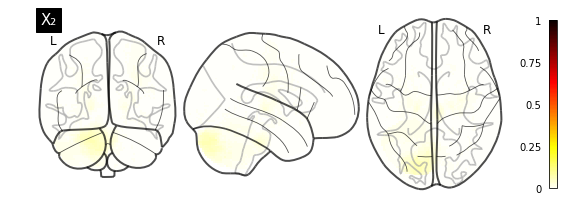

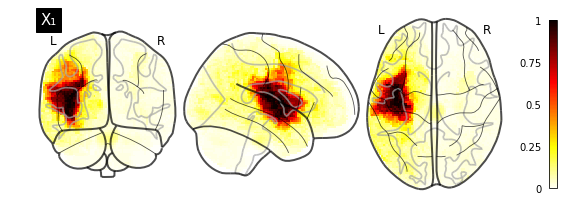

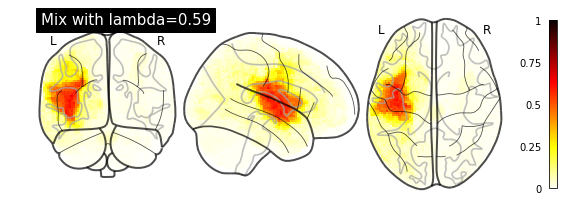

-------------------------------------------------------------------------------------------------------------

Scores for X₁:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Scores for X₂:		 [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]
Lambda:			 1.0
Scores for mixup-ed data: [ 0.38166655  0.29427232 -1.6606527  -0.97924129 -0.29475448 -0.75458535]


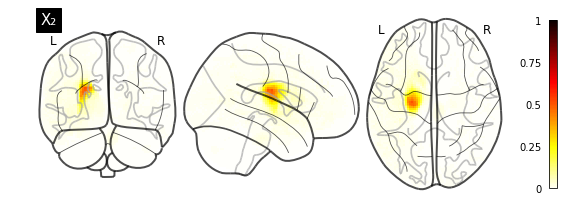

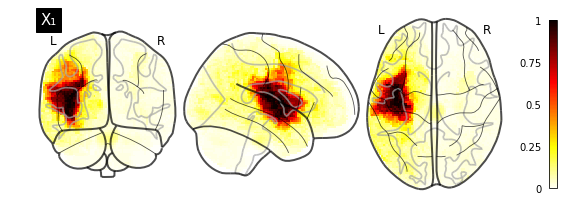

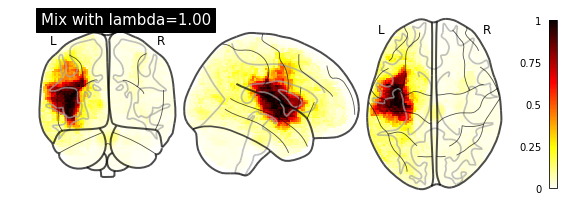

In [39]:
# visualize some samples 
j=0
# for i in sample(range(len(mixed_X)), 35):
for p in range(5):
    
    i = 1401*j + 459 # because sample 459 is good for visualization.
    print("-------------------------------------------------------------------------------------------------------------\n")
    print("Scores for X\N{SUBSCRIPT ONE}:\t\t", Y[X1_idx[i]])
    print("Scores for X\N{SUBSCRIPT TWO}:\t\t", Y[X1_idx[i]])
    print("Lambda:\t\t\t", lambdas[i])
    print("Scores for mixup-ed data:", mixed_Y[i])
    
    x1_it = masker.inverse_transform(pca.inverse_transform(X_pc[X1_idx[i]]))
    x2_it = masker.inverse_transform(pca.inverse_transform(X_pc[X2_idx[i]]))
    mixed_it = masker.inverse_transform(pca.inverse_transform(mixed_X[i]))
     
#     plotting.plot_glass_brain(x2_it, colorbar=True, title='id='+str(X2_idx[i]), vmin=0, vmax=1)
#     plotting.plot_glass_brain(x1_it, colorbar=True, title='id='+str(X1_idx[i]), vmin=0, vmax=1) 
    plotting.plot_glass_brain(x2_it, colorbar=True, title="X\N{SUBSCRIPT TWO}", vmin=0, vmax=1)
    plotting.plot_glass_brain(x1_it, colorbar=True, title="X\N{SUBSCRIPT ONE}", vmin=0, vmax=1)
    plotting.plot_glass_brain(mixed_it, colorbar=True, title='Mix with lambda='+"{:.2f}".format(lambdas[i]), vmin=0, vmax=1)
    plt.show()
    j+=1
    

In [11]:
5

5